# A Classic from David MacKay
- categories: [Julia, Turing]

A classic textbook in information theory is [Information Theory](https://inst.eecs.berkeley.edu//~ee121/sp08/handouts/it.pdf), by David MacKay. When I was first starting out, I came across this book (it is, after all, free - graduate students rejoice!) and I really enjoyed his exposition on p. 48 about "a first inference problem." I recommend reading it if you haven't, it's great.

Anyway, I've reproduced the problem here and I'll share a Turing solution below.

![image.png](images/mackay.png)

The trickiness comes from the window which truncates the data. This is actually super easy to accomplish in Stan, Turing, etc with basically single line changes to the most natural model.

In [1]:
#collapse
using Turing
using Bijectors
using Gadfly
using DataFrames, DataFramesMeta
#using Zygote
#Turing.setadbackend(:zygote)
Gadfly.set_default_plot_size(900px, 300px)

Here's how things look in the simpler case where there is no truncation.

$$\begin{aligned}
\lambda &\sim \mathrm{Exponential}(100)\\
d_i &\sim \mathrm{Exponential}(\lambda)\\
\end{aligned}$$

And some data to match:

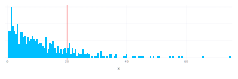

In [73]:
λ_true = 12.0
data = rand(Exponential(λ_true), 500)
plot(DataFrame(x=data),x=:x, xintercept=[20],
    Geom.histogram, Geom.vline(color="red"),
    Coord.cartesian(xmin=0.0, ymin=0.0), Guide.yticks(label = false))

You can see that even though $\lambda0$ < 20 the window (red) would still truncate quite a bit of the data in the original problem description. Here's the model written out in Turing:

In [74]:
@model function decay_estimator(decays::Array{Float64})
    λ ~ Uniform(0, 30)
    T = typeof(λ)
    decays ~ filldist(Exponential(λ), length(decays))
end;

In [75]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.02
τ = 10;

λ_chain = sample(
    decay_estimator(data),
    HMC(ϵ, τ), iterations, 
    progress=true, drop_warmup=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [76]:
mean(data)

11.921870025729818

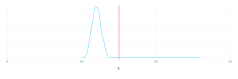

In [77]:
#collapse
plot(DataFrame(λ_chain), x=:λ, xintercept=[λ0], Theme(alphas=[0.6]),
    Geom.density, Geom.vline(color="red"),
    Coord.cartesian(ymin=0.0), Guide.yticks(label = false))

Well this model pretty much nails it. The original value of $\lambda_0$ was 15 and that peak is right on the money. Let's try the same model with truncated data... :grimacing:!

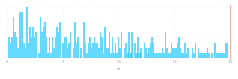

In [78]:
data_trunc = [d for d in data if d <= 20.0]
plot(DataFrame(x=data_trunc),x=:x, xintercept=[20], Theme(alphas=[0.6]),
    Geom.histogram, Geom.vline(color="red"),
    Coord.cartesian(xmin=0.0, ymin=0.0), Guide.yticks(label = false))

In [79]:
λ_trunc_chain = sample(
    decay_estimator(data_trunc), 
    HMC(ϵ, τ), iterations, 
    progress=false, drop_warmup=true);

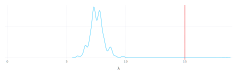

In [80]:
#collapse
trunc_df = @where(DataFrame(λ_trunc_chain), :λ .< 50)
plot(trunc_df, x=:λ, xintercept=[λ0], Theme(alphas=[0.6]),
    Geom.density, Geom.vline(color="red"),
    Coord.cartesian(xmin=0.0, ymin=0.0), Guide.yticks(label = false))

That is most definitely not correct. So, we'll need a new model.

$$\begin{aligned}
\lambda &\sim \mathrm{Exponential}(100)\\
d_i &\sim \mathrm{Exponential}(\lambda)\vert_{0}^{20}\\
\end{aligned}$$

> Note: I'm not aware of any specific notation for truncated distributions (and I spent like 3 whole minutes looking) so $\mathcal{D}(x)|_{a}^{b}$ seemed fine.

In [81]:
@model function decay_estimator_trunc(decays::Array{Float64})
    λ ~ Exponential(100)
    T = typeof(λ)
    for i in 1:length(decays)
        decays[i] ~ truncated(Exponential(λ), T(0.0), T(20.0))
    end
end;

In [82]:
λ_trunc_correct_chain = sample(
    decay_estimator_trunc(data_trunc), 
    HMC(ϵ, τ), iterations, 
    progress=false, drop_warmup=true);

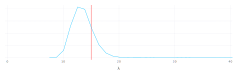

In [87]:
#collapse
plot(DataFrame(λ_trunc_correct_chain), x=:λ, xintercept=[λ0], Theme(alphas=[0.6]),
    Geom.density, Geom.vline(color="red"),
    Coord.cartesian(xmin=0.0, xmax=40.0, ymin=0.0), Guide.yticks(label = false))